In [130]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import pingouin as pg
import plotly.express as px
import seaborn as sns 
from statannot import add_stat_annotation
import os
import copy
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [95]:
def read_data(path):
    data_raw = []
    data_auto = []
    data_control = []
    data_self = []
    for home, dirs, files in os.walk(path):
        for filename in files:
            t = pd.read_csv(home+"/"+filename,index_col=0)
            t = t[90:-1].reset_index()
            t[["participant_id"]] = filename[1:3]
            t[["condition"]] = filename[4:8]
            t[["missionTargetName"]] = t[["missionTargetName"]].replace(['MissionPanel'],np.nan)
            if filename[4:8] == "auto":
                data_auto.append(t)
            elif filename[4:8] == "cont":
                data_control.append(t)
            elif filename[4:8] == "self":
                data_self.append(t)
            data_raw.append(t)
            # print(filename[1:3] + "_" + filename[4:8])
    return data_raw, data_auto, data_control, data_self

In [96]:
## Test the normality of the data
def test_normality(data_raw):
    normal_condition = []
    for i in range(len(data_raw)):
        normal_condition.append(pg.normality(data_raw[i]['Trend_Sum']))
    return normal_condition



In [151]:
## Calculate the time of each mission ##
def total_data_analysis(data_raw):
    labels = [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]
    data_analysis = pd.DataFrame()
    for i in range(len(data_raw)):      
        mission_time = np.zeros(4)
        time_all = len(data_raw[i])/90
        condition = data_raw[i][["condition"]][0:1].values.ravel()[0]
        participant_id = data_raw[i][["participant_id"]][0:1].values.ravel()[0]
        label = labels[int(participant_id)-1]

        # print(participant_id + condition)

        time_point = data_raw[i][["missionTargetName"]].duplicated()
        order = time_point[time_point == False]
        for j in range(len(order)-1):
            mission_time[j] = ((order.index[j+1] - order.index[j])/90)        
        
        mission_completed = float(len(order)-1)
        time_1 = mission_time[0]
        time_2 = mission_time[1]
        time_3 = mission_time[2]
        time_4 = mission_time[3]
        
        cogload_average = (np.average(data_raw[i]["Trend_Sum"]))
        damage_find = float(len(data_raw[i].damageTargetName.unique()) - 1)

        data_analysis = data_analysis.append(pd.DataFrame([[condition,participant_id,label,mission_completed,time_all,time_1,time_2,time_3,time_4,cogload_average,damage_find]],
                                                columns=["condition","participant_id","label","mission_completed","time_all","time_1","time_2","time_3","time_4","cogload_average","damage_find"]),
                                                ignore_index=True)
    
    return data_analysis

In [152]:
path = '../../data/test/'
(data_raw, data_auto, data_control, data_self) = read_data(path)
data_analysis = total_data_analysis(data_raw)



c:\A\software\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning:

Columns (41) have mixed types.Specify dtype option on import or set low_memory=False.

c:\A\software\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning:

Columns (40) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
test_normality(data_raw)

In [153]:
### test ###
data_analysis

,condition,participant_id,label,mission_completed,time_all,time_1,time_2,time_3,time_4,cogload_average,damage_find
0,auto,01,0,4.0,350.477778,90.533333,63.933333,45.655556,150.322222,0.468730,2.0
1,cont,01,0,3.0,387.511111,99.744444,55.288889,52.444444,0.000000,0.327164,3.0
2,self,01,0,2.0,511.477778,58.077778,273.355556,0.000000,0.000000,0.557953,2.0
3,auto,02,0,3.0,392.500000,74.388889,219.844444,98.244444,0.000000,0.922625,3.0
4,cont,02,0,4.0,263.444444,53.244444,55.811111,30.122222,124.233333,0.974022,3.0
5,self,02,0,4.0,257.333333,45.922222,73.677778,25.122222,112.577778,1.050457,3.0
6,auto,03,0,4.0,277.233333,32.122222,114.666667,37.344444,93.066667,0.494752,3.0
7,cont,03,0,4.0,273.422222,40.000000,93.811111,25.222222,114.366667,0.612531,4.0
8,self,03,0,3.0,465.466667,45.866667,92.111111,327.455556,0.000000,1.005163,3.0
9,auto,04,0,3.0,406.500000,45.977778,294.177778,66.311111,0.000000,-0.257995,4.0


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

auto v.s. cont: Kruskal-Wallis paired samples, P_val=6.610e-01 stat=1.923e-01
cont v.s. self: Kruskal-Wallis paired samples, P_val=8.221e-01 stat=5.053e-02
auto v.s. self: Kruskal-Wallis paired samples, P_val=7.382e-01 stat=1.117e-01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

auto v.s. cont: Kruskal-Wallis paired samples, P_val=4.662e-01 stat=5.309e-01
cont v.s. self: Kruskal-Wallis paired samples, P_val=4.176e-01 stat=6.569e-01
auto v.s. self: Kruskal-Wallis paired samples, P_val=1.284e-01 stat=2.311e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

auto v.s. cont: Kruskal-Wallis paired sa

[Text(0.5, 42.25, 'Kruskal analysis between groups'),
 Text(1165.4558823529412, 0.5, 'time_all')]

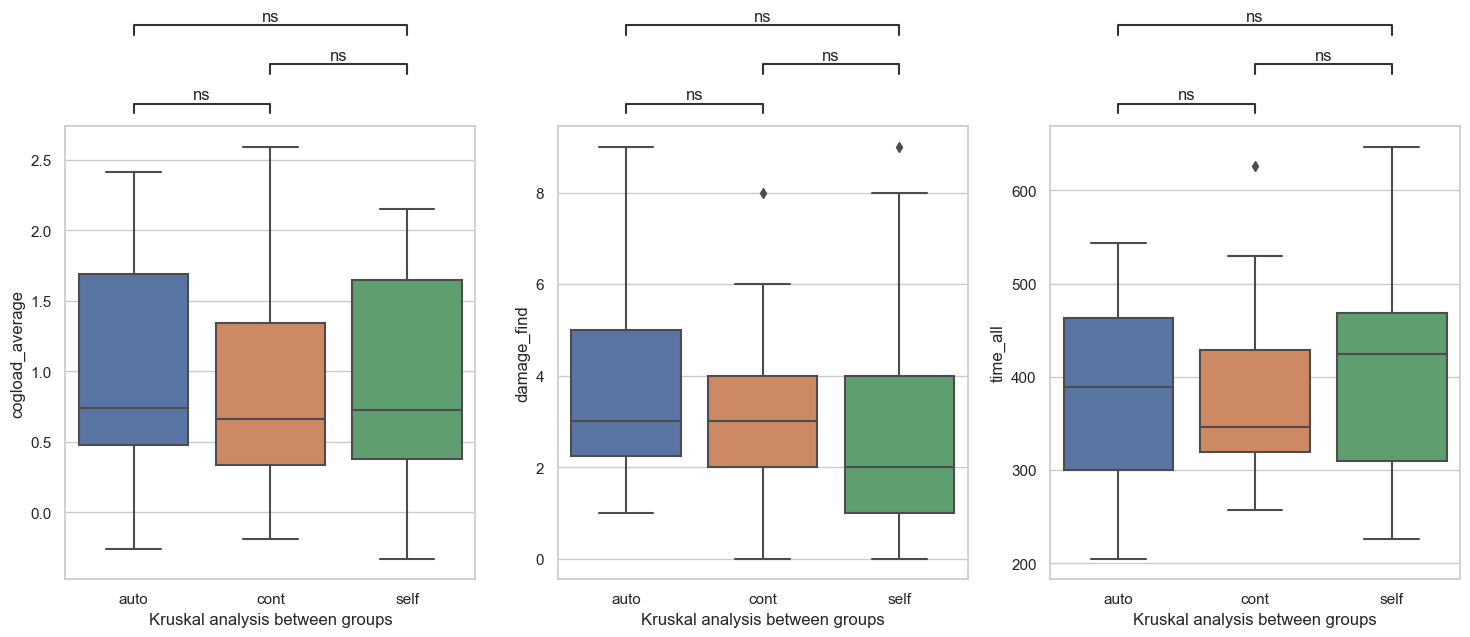

In [100]:
### pair analysis visualization 
sns.set(style = 'whitegrid')
x = 'condition'
order = ["auto", "cont","self"]
method = 'Kruskal'

fig, axes = plt.subplots(1,3, figsize=(18,6), dpi=100)

y = 'cogload_average'
axes[0] = sns.boxplot(ax = axes[0], data=data_analysis, x=x, y=y, order=order)
test_results = add_stat_annotation(ax=axes[0], data=data_analysis, x=x, y=y, order=order,
                                 box_pairs=[
                                          (order[0], order[1]),
                                          (order[0], order[2]),
                                          (order[1], order[2]),
                                             ],
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 )
axes[0].set(xlabel = method + ' analysis between groups', ylabel=y)

y = "damage_find"
axes[1] = sns.boxplot(ax = axes[1],data=data_analysis, x=x, y=y,order=order,)
test_results = add_stat_annotation(ax=axes[1], data=data_analysis, x=x, y=y,
                                 box_pairs=[
                                          (order[0], order[1]),
                                          (order[0], order[2]),
                                          (order[1], order[2]),
                                          ],
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 )
axes[1].set(xlabel = method + ' analysis between groups', ylabel=y)

y = "time_all"
axes[2] = sns.boxplot(ax = axes[2],data=data_analysis, x=x, y=y,order=order,)
test_results = add_stat_annotation(ax=axes[2], data=data_analysis, x=x, y=y,
                                 box_pairs=[
                                          (order[0], order[1]),
                                          (order[0], order[2]),
                                          (order[1], order[2]),
                                          ],
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 )
axes[2].set(xlabel = method + ' analysis between groups', ylabel=y)

In [101]:
### sample from raw data 
rate = 20
data_image = copy.deepcopy(data_auto[1])
subset = data_image[::rate]
## 3D Stastic ###
if 1:
    df = subset
    fig = px.scatter_3d(df, x='CameraPosX', y='CameraPosY', z='CameraPosZ',
                color='Trend_Sum',color_continuous_scale=px.colors.sequential.Viridis,symbol='light_state',symbol_sequence=["cross","circle"],opacity=0.8,)
    fig.update_traces(marker_size = 3)
    fig.show()

In [102]:
# TEST UI CHANGE #
i = 1
data_light = copy.deepcopy(data_auto[i])
data_light["state_change"] = data_light["light_state"].diff()
column_changes = data_light[data_light['state_change'] != 0]
UI_dark_list = column_changes["light_state"][column_changes["light_state"]==False].index
window = 500
cog_before = []
cog_after = []
for i in range(len(UI_dark_list)):
    cog_before.append(np.average(data_light["Trend_Sum"][UI_dark_list[i]-window:UI_dark_list[i]]))
    cog_after.append(np.average(data_light["Trend_Sum"][UI_dark_list[i]:UI_dark_list[i]+window]))
print(cog_before)
print(cog_after)

[1.1703844834, 1.1493368282, 1.1814254228, 0.9317546062, 0.9448417047999997, 1.108159962, 0.8812486236]
[1.0086858928000002, 0.8388293776000001, 1.0109514327999998, 0.8907129792, 1.3740564134, 1.2647457568000002, 1.0122407266]


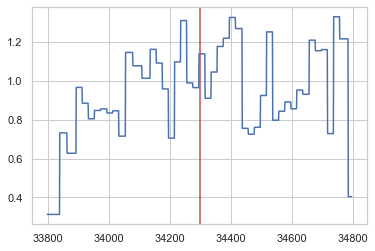

In [103]:
i = 6
plt.plot(data_light["Trend_Sum"][UI_dark_list[i]-window:UI_dark_list[i]+window])
plt.axvline(x=UI_dark_list[i],c="r")
plt.show()

In [104]:
before_df = pd.DataFrame()
after_df = pd.DataFrame()
for i in range(len(data_auto)):
   data_light = copy.deepcopy(data_auto[i])
   data_light["state_change"] = data_light["light_state"].diff()
   column_changes = data_light[data_light['state_change'] != 0]
   UI_dark_list = column_changes["light_state"][column_changes["light_state"]==False].index
   window = 360
   for j in range(len(UI_dark_list)):
      before_df = before_df.append(pd.DataFrame(data_auto[i]["Trend_Sum"][UI_dark_list[j]-window:UI_dark_list[j]].values,columns=["Trend_Sum"]))
      after_df = after_df.append(pd.DataFrame(data_auto[i]["Trend_Sum"][UI_dark_list[j]:UI_dark_list[j]+window].values,columns=["Trend_Sum"]))

group_1 = "Before_UI_dark"
group_2 = "After_UI_dark"

before_df["Groups"] = group_1
after_df["Groups"] = group_2

combine_df = pd.concat([before_df,after_df])
combine_df.columns = ["CogLoad","Groups"]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Before_UI_dark v.s. After_UI_dark: Kruskal-Wallis paired samples, P_val=2.492e-05 stat=1.777e+01


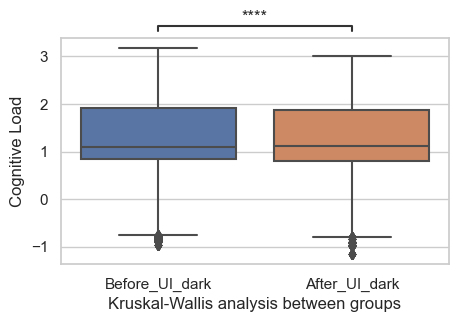

In [105]:
data = combine_df
x = 'Groups'
y = 'CogLoad'
hue = 'Groups'
order = [group_1, group_2]

sns.set(style = 'whitegrid')
fig, axes = plt.subplots(1,1, figsize=(5,3), dpi=100)

if 1:
   axes = sns.boxplot(ax = axes, data=data, x=x, y=y, order=order)
   test_results = add_stat_annotation(ax=axes, data=data, x=x, y=y, order=order,
                                    box_pairs=[(order[0], order[1])],
                                    test='Kruskal', 
                                    # test='Wilcoxon', 
                                    comparisons_correction=None, 
                                    text_format='star', loc='outside', verbose=2,
                                    #   stats_params={'alternative': 'greater'}
                                    )
   # axes.set(xlabel='Paired analysis between conditions (Greater)', ylabel='VRSQ score')
   axes.set(xlabel='Kruskal-Wallis analysis between groups', ylabel='Cognitive Load')
   # axes.set(xlabel='Wilcoxon analysis between groups', ylabel='Mission time (s)')
   # axes.set(xlabel='Wilcoxon analysis between groups', ylabel='Average cognitive load')

In [107]:
data_analysis_lightstate = pd.DataFrame()
for i in range(len(data_auto)):
   light_group = data_auto[i].groupby(["light_state"]).get_group(1)
   condition = "light"
   cogload_average = (np.average(light_group["Trend_Sum"]))
   damage_find = float(len(light_group.damageTargetName.unique()) - 1)
   data_analysis_lightstate = data_analysis_lightstate.append(pd.DataFrame([[condition,cogload_average,damage_find]],
                                          columns=["condition","cogload_average","damage_find"]),
                                          ignore_index=True)   
   
   condition = "dark"
   if len(data_auto[i].light_state.unique()) == 1:
      cogload_average = np.nan
      damage_find = np.nan      
   elif len(data_auto[i].light_state.unique()) == 2:
      dark_group = data_auto[i].groupby(["light_state"]).get_group(0)
      cogload_average = (np.average(dark_group["Trend_Sum"]))
      damage_find = float(len(dark_group.damageTargetName.unique()) - 1)
   
   data_analysis_lightstate = data_analysis_lightstate.append(pd.DataFrame([[condition,cogload_average,damage_find]],
                                          columns=["condition","cogload_average","damage_find"]),
                                          ignore_index=True)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

light v.s. dark: Kruskal-Wallis paired samples, P_val=8.266e-02 stat=3.012e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

light v.s. dark: Kruskal-Wallis paired samples, P_val=1.207e-01 stat=2.408e+00


[Text(0.5, 42.25, 'Kruskal analysis between groups'),
 Text(630.0227272727271, 0.5, 'damage_find')]

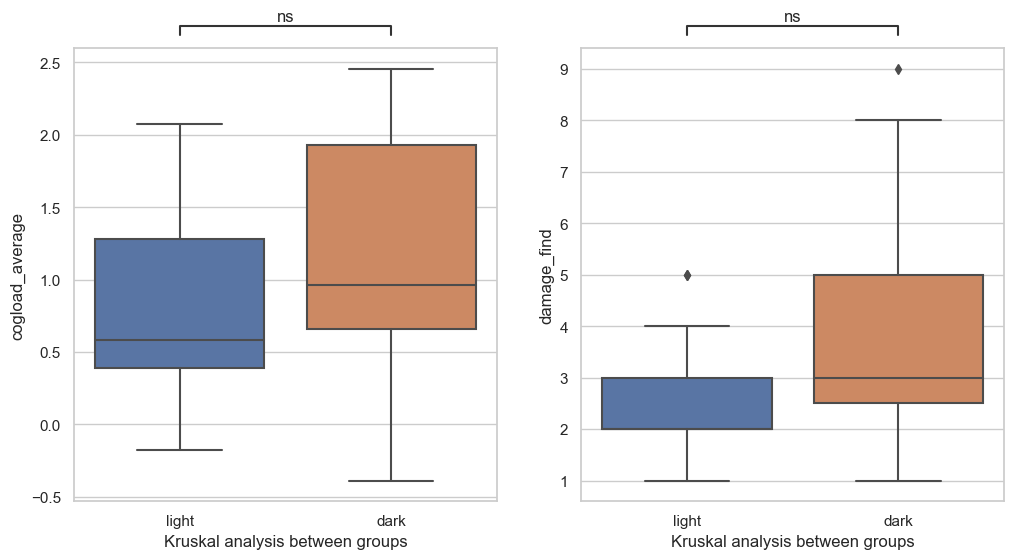

In [108]:
data = data_analysis_lightstate
x = 'condition'
order = ["light", "dark"]
sns.set(style = 'whitegrid')

fig, axes = plt.subplots(1,2, figsize=(12,6), dpi=100)
y = 'cogload_average'
axes[0] = sns.boxplot(ax = axes[0], data=data, x=x, y=y, order=order)
test_results = add_stat_annotation(ax=axes[0], data=data, x=x, y=y, order=order,
                                 box_pairs=[
                                          (order[0], order[1]),
                                             ],
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 )
axes[0].set(xlabel = method + ' analysis between groups', ylabel=y)

y = "damage_find"
axes[1] = sns.boxplot(ax = axes[1],data=data, x=x, y=y,order=order,)
test_results = add_stat_annotation(ax=axes[1], data=data, x=x, y=y,
                                 box_pairs=[
                                          (order[0], order[1]),
                                          ],
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 )
axes[1].set(xlabel = method + ' analysis between groups', ylabel=y)


In [ ]:
################################################# segment participant ########################################################################

In [156]:
label_small_group = data_analysis.groupby(["label"]).get_group(0)
label_large_group = data_analysis.groupby(["label"]).get_group(1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

auto v.s. cont: Kruskal-Wallis paired samples, P_val=6.310e-01 stat=2.308e-01
cont v.s. self: Kruskal-Wallis paired samples, P_val=3.367e-01 stat=9.231e-01
auto v.s. self: Kruskal-Wallis paired samples, P_val=4.233e-01 stat=6.410e-01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

auto v.s. cont: Kruskal-Wallis paired samples, P_val=8.712e-01 stat=2.628e-02
cont v.s. self: Kruskal-Wallis paired samples, P_val=8.712e-01 stat=2.628e-02
auto v.s. self: Kruskal-Wallis paired samples, P_val=8.719e-01 stat=2.600e-02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

auto v.s. cont: Kruskal-Wallis paired sa

[Text(0.5, 42.25, 'Kruskal analysis between groups'),
 Text(1165.4558823529412, 0.5, 'time_all')]

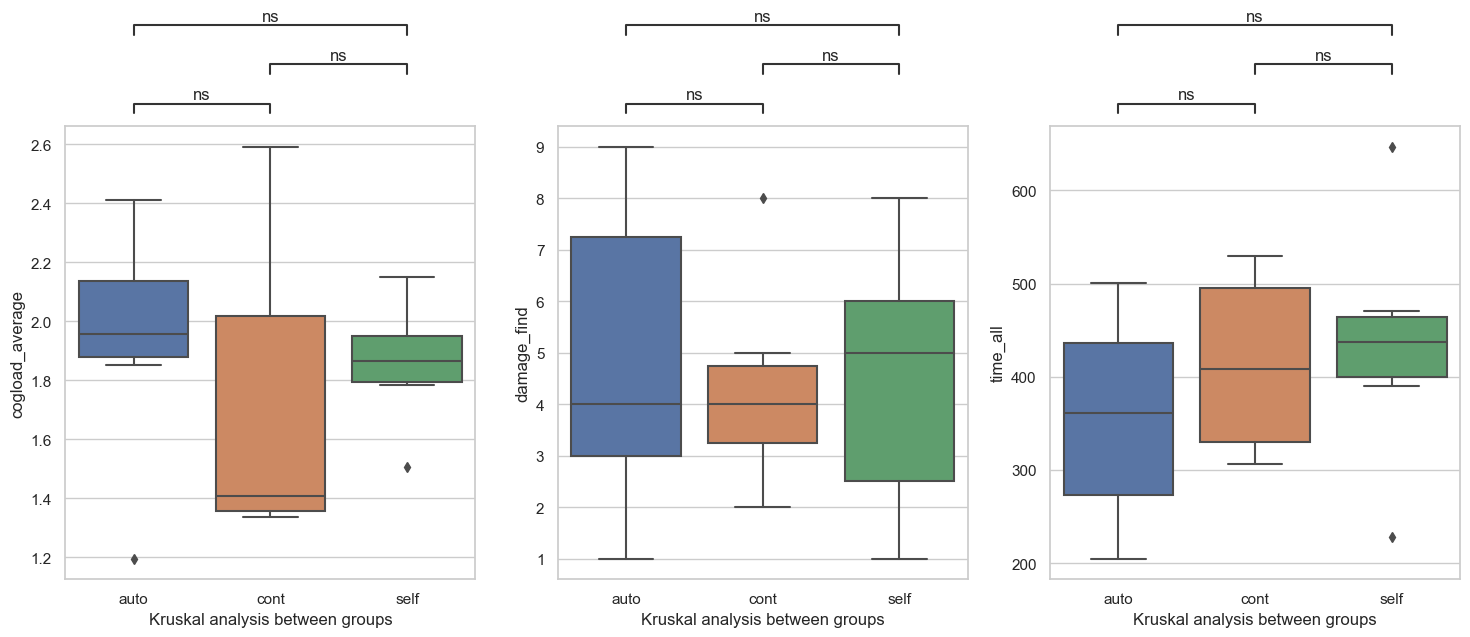

In [158]:
### pair analysis visualization 
data = label_large_group
sns.set(style = 'whitegrid')
x = 'condition'
order = ["auto", "cont","self"]
method = 'Kruskal'

fig, axes = plt.subplots(1,3, figsize=(18,6), dpi=100)

y = 'cogload_average'
axes[0] = sns.boxplot(ax = axes[0], data=data, x=x, y=y, order=order)
test_results = add_stat_annotation(ax=axes[0], data=data, x=x, y=y, order=order,
                                 box_pairs=[
                                          (order[0], order[1]),
                                          (order[0], order[2]),
                                          (order[1], order[2]),
                                             ],
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 )
axes[0].set(xlabel = method + ' analysis between groups', ylabel=y)

y = "damage_find"
axes[1] = sns.boxplot(ax = axes[1],data=data, x=x, y=y,order=order,)
test_results = add_stat_annotation(ax=axes[1], data=data, x=x, y=y,
                                 box_pairs=[
                                          (order[0], order[1]),
                                          (order[0], order[2]),
                                          (order[1], order[2]),
                                          ],
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 )
axes[1].set(xlabel = method + ' analysis between groups', ylabel=y)

y = "time_all"
axes[2] = sns.boxplot(ax = axes[2],data=data, x=x, y=y,order=order,)
test_results = add_stat_annotation(ax=axes[2], data=data, x=x, y=y,
                                 box_pairs=[
                                          (order[0], order[1]),
                                          (order[0], order[2]),
                                          (order[1], order[2]),
                                          ],
                                 test=method, 
                                 comparisons_correction=None, 
                                 text_format='star', loc='outside', verbose=1,
                                 )
axes[2].set(xlabel = method + ' analysis between groups', ylabel=y)

In [ ]:
######################### k-means clustering ##################################

In [110]:
participant_group = data_analysis.groupby(["participant_id"])

In [115]:
average_participant_cogload = []
for h,d in participant_group:
    average_participant_cogload.append(np.mean(d[["cogload_average"]].values))

In [119]:
## gap statistic ## 
import scipy
import scipy.cluster.vq
import scipy.spatial.distance
import numpy as np
EuclDist = scipy.spatial.distance.euclidean
def gapStat(data, resf=None, nrefs=50, ks=range(1,20)):
    '''
    Gap statistics
    '''
    # MC
    shape = data.shape
    if resf == None:
        x_max = data.max(axis=0)
        x_min = data.min(axis=0)
        dists = np.matrix(np.diag(x_max-x_min))
        rands = np.random.random_sample(size=(shape[0], shape[1], nrefs))
        for i in range(nrefs):
            rands[:,:,i] = rands[:,:,i]*dists+x_min
    else:
        rands = refs
    s1 = np.zeros((len(ks),))
    s2 = np.zeros((len(ks),))
    gaps = np.zeros((len(ks),))
    gapDiff = np.zeros(len(ks)-1,)
    sdk = np.zeros(len(ks),)
    for (i,k) in enumerate(ks):
        (cluster_mean, cluster_res) = scipy.cluster.vq.kmeans2(data, k)
        Wk = sum([EuclDist(data[m,:], cluster_mean[cluster_res[m],:]) for m in range(shape[0])])
        WkRef = np.zeros((rands.shape[2],))
        for j in range(rands.shape[2]):
            (kmc,kml) = scipy.cluster.vq.kmeans2(rands[:,:,j], k)
            WkRef[j] = sum([EuclDist(rands[m,:,j],kmc[kml[m],:]) for m in range(shape[0])])
        s1[i] = scipy.log(Wk)
        s2[i] = scipy.log(scipy.mean(WkRef))
        gaps[i] = scipy.log(scipy.mean(WkRef))-scipy.log(Wk)
        sdk[i] = np.sqrt((1.0+nrefs)/nrefs)*np.std(scipy.log(WkRef))

        if i > 0:
            gapDiff[i-1] = gaps[i-1] - gaps[i] + sdk[i]
    return gaps, gapDiff, s2, s1

<ipython-input-119-0f0756815383>:34: DeprecationWarning:

scipy.log is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.log instead

<ipython-input-119-0f0756815383>:35: DeprecationWarning:

scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead

<ipython-input-119-0f0756815383>:35: DeprecationWarning:

scipy.log is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.log instead

<ipython-input-119-0f0756815383>:36: DeprecationWarning:

scipy.mean is deprecated and will be removed in SciPy 2.0.0, use numpy.mean instead

<ipython-input-119-0f0756815383>:36: DeprecationWarning:

scipy.log is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.log instead

<ipython-input-119-0f0756815383>:37: DeprecationWarning:

scipy.log is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.log instead

c:\A\software\Anaconda3\lib\site-packages\scipy\cluster\vq.py:575: UserWarning:

One of the clusters i

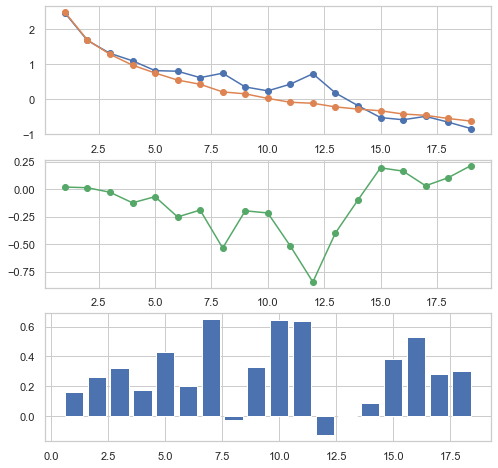

In [135]:
gaps,gapsDiff, s2, s1 = gapStat(np.array(average_participant_cogload).reshape(-1, 1))
X = range(1,20)
f, (a1,a2,a3) = plt.subplots(3,1,figsize=(8,8))
a1.plot(X,s1,'o-')
a1.plot(X,s2,'o-')
a2.plot(X,gaps, 'g-o')
a3.bar(np.arange(1,19),gapsDiff)
f.show()

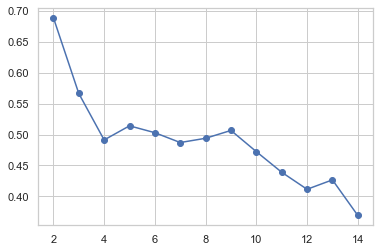

In [134]:
## Silhouette Coefficient ##
Scores = []
for i in range(2,15):
    estimator = KMeans(i)
    estimator.fit(np.array(average_participant_cogload).reshape(-1, 1))
    Scores.append(silhouette_score(np.array(average_participant_cogload).reshape(-1, 1),estimator.labels_,metric='euclidean'))
X = range(2,15)
plt.plot(X,Scores,'o-')

In [138]:
n_clus = 2
kmeans_clustering = KMeans(n_clusters=n_clus, random_state=0).fit(np.array(average_participant_cogload).reshape(-1,1))
labels = kmeans_clustering.labels_
# joblib.dump(sax_kmeans_left, path + 'sax_kmeans_left.pkl')
# test_model = joblib.load(path + 'sax_kmeans.pkl') 
print(labels)


[0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 1 0]


In [142]:
cluster_df = pd.DataFrame()
for i in range(len(average_participant_cogload)):
    participant_id = i+1
    average_load = average_participant_cogload[i]
    participant_label = labels[i]
    cluster_df = cluster_df.append(pd.DataFrame([[participant_id,average_load,participant_label]],
                                                columns=["participant_id","average_load","participant_label"]),
                                                ignore_index=True)

In [143]:
cluster_df

,participant_id,average_load,participant_label
0,1,0.451282,0
1,2,0.982368,0
2,3,0.704149,0
3,4,-0.258556,0
4,5,0.555866,0
5,6,1.357871,1
6,7,1.971352,1
7,8,2.025945,1
8,9,0.395342,0
9,10,0.887204,0
